# Data Mart configuration and usage with `ibm-ai-openscale` python package

<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/image.png" align="left" alt="banner" width="100">

This notebook shows hot to create a data mart for Watson Machine Learning deployments. It includes steps for performance, bias and quality monitor configurations.

Contents
- [1. Setup](#setup)
- [2. Binding machine learning engine](#binding)
- [3. Subscriptions](#subscription)
- [4. Score models](#scoring)
- [5. Data Mart](#datamart)
- [6. Visualization](#visualization)

<a id="setup"></a>
## 1. Setup

### 1.1 Installation and authentication

In [ ]:
!pip install --upgrade ibm-ai-openscale

In [ ]:
!pip install --upgrade watson-machine-learning-client

### ACTION: Restart kernel to make sure installed versions are used.

Import and initiate.

In [1]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### ACTION: Get `instance_id` (GUID) and `apikey`

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get DATA_MART_ID (this is AI OpenScale instance GUID)
```
bx target -g <myResourceGroup>
bx resource service-instance ‘instance_name’
```


In [2]:
aios_credentials = {
  "instance_id": "*****",
  "apikey": "*****", 
  "url": "https://api.aiopenscale.cloud.ibm.com"
}

In [3]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your Watson Machine Learning credentials here

In [4]:
wml_credentials =  {
  "apikey": "***",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/181ed6cc388f47bd9d862fe066f9cfce:c419e24a-c4eb-41b4-a2e1-ce4f0d298428::",
  "iam_apikey_name": "auto-generated-apikey-33f864a1-9958-4a32-b9ab-6fd962f98522",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/181ed6cc388f47bd9d862fe066f9cfce::serviceid:ServiceId-e847629a-195e-455d-a949-957263b867ab",
  "instance_id": "***",
  "password": "***",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "*****"
}

In [5]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your PostgreSQL credentials here

In [6]:
postgres_credentials = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
client = APIClient(aios_credentials)

In [9]:
client.version

'1.0.92'

Put your schema name here.

In [11]:
schemaName = 'data_mart_service'

You can use the code below to create the schema. If the schema already exists skipp this cell.

In [12]:
import psycopg2

hostname = postgres_credentials['uri'].split('@')[1].split(':')[0]
port = postgres_credentials['uri'].split('@')[1].split(':')[1].split('/')[0]
user = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[0]
password = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[1]
dbname = 'compose'

conn_string = "host=" + hostname + " port=" + port + " dbname=" + dbname + " user=" + user + " password=" + password
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()
try:
    query = "drop schema " + schemaName + " cascade"
    cursor.execute(query)
except:
    pass
finally:    
    try:
        query = "create schema " + schemaName
        cursor.execute(query)
    finally:    
        conn.close()

### 1.2 DataMart setup

In [18]:
client.data_mart.setup(db_credentials=postgres_credentials, schema=schemaName)

In [19]:
data_mart_details = client.data_mart.get_details()

Data Mart with instance id name has been created.

<a id="binding"></a>

## 2. Bind machine learning engines

### 2.1 Bind Watson Machine Learning 

You can bind you Watson Machine Learning instance to previously created data mart.

In [20]:
binding_uid = client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(wml_credentials))

In [21]:
bindings_details = client.data_mart.bindings.get_details()

In [22]:
client.data_mart.bindings.list()

e4e87cbb-f343-4acb-a2bb-b652d82bea38,WML instance,watson_machine_learning,2018-11-15T14:45:25.100Z


### 2.2 Check available assets from binded services

#### List available assets

In [23]:
client.data_mart.bindings.list_assets()

eea0e3cf-9291-425f-834d-a67b42f9fad8,CARS4U - Action Recommendation Model,2018-11-15T14:41:38.188Z,model,mllib-2.1,e4e87cbb-f343-4acb-a2bb-b652d82bea38,F


#### Get metadata of available assets

In [24]:
assets_details = client.data_mart.bindings.get_asset_details()

In [25]:
cars4u_asset_uid = None

for x in client.data_mart.bindings.get_asset_details():
    if 'cars4u' in x['name'].lower():
        cars4u_asset_uid = x['source_uid']

In [26]:
print(str(cars4u_asset_uid))

eea0e3cf-9291-425f-834d-a67b42f9fad8


<a id="subscriptions"></a>
## 3. Subscriptions

### 3.1 Subscribe the asset

In [27]:
subscription = client.data_mart.subscriptions.add(WatsonMachineLearningAsset(cars4u_asset_uid))

#### Get subscriptions list

In [28]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['eea0e3cf-9291-425f-834d-a67b42f9fad8']


#### List subscriptions

In [29]:
client.data_mart.subscriptions.list()

eea0e3cf-9291-425f-834d-a67b42f9fad8,CARS4U - Action Recommendation Model,model,e4e87cbb-f343-4acb-a2bb-b652d82bea38,2018-11-15T14:45:49.773Z


#### Get subscription

**Hint:** You can get subscription by passing subscription_uid to below method.

### 3.2 Enable payload logging and performance monitor for subscribed assets

In [30]:
for uid in subscriptions_uids:
    subscription = client.data_mart.subscriptions.get(uid)
    subscription.payload_logging.enable()
    subscription.performance_monitoring.enable()

#### Get details of enabled payload logging

In [31]:
payload_logging_details = subscription.payload_logging.get_details()

#### Print schema of payload_logging table

In [32]:
subscription.payload_logging.print_table_schema()

ID,int4,4,-,-,N
Gender,text,-,-,-,N
Status,text,-,-,-,N
Children,int4,4,-,-,N
Age,float8,8,-,-,N
Customer_Status,text,-,-,-,N
Car_Owner,text,-,-,-,N
Customer_Service,text,-,-,-,N
Satisfaction,int4,4,-,-,N
Business_Area,text,-,-,-,N
prediction,float8,8,-,-,N


### 3.3 Enable Quality (Accuracy) monitor

#### Enable quality monitor for selected subscription

In [33]:
subscription.quality_monitoring.enable(evaluation_method='multiclass', threshold=0.7, min_records=5)

#### Send some feedback records to feedback store. 

Feedback records are used to evaluate our model.

In [34]:
subscription.feedback_logging.store(
            [
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA'],
                [123, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [124, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA'],
                [3785, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [3786, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [3787, 'Male', 'S', 1, 17, 'Active', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA']
            ],
            fields=['ID', 'Gender', 'Status', 'Children', 'Age', 'Customer_Status', 'Car_Owner', 'Customer_Service', 'Satisfaction', 'Business_Area', 'Action']
        )

**Hint:** Accuracy (Quality) monitor is executed every hour. You can also run it on demand using below command.

In [35]:
run_details = subscription.quality_monitoring.run()

You can also check evaluation run details using below command.

In [36]:
subscription.quality_monitoring.get_run_details(run_details['id'])

{'completed_at': '2018-11-15T14:47:34.230Z',
 'data_mart_id': '534671bf-88e8-4ac9-a18a-817640c89447',
 'flags': {'batch_size': 1000,
  'fetch_size': 1000,
  'parallelism': 4,
  'window_in_millis': 2000},
 'id': '0ec467a0-e220-408c-8218-042feda6bda1',
 'metrics': {'accuracy': 0.5,
  'weightedFMeasure': 0.625,
  'weightedFalsePositiveRate': 0.0,
  'weightedPrecision': 1.0,
  'weightedRecall': 0.5,
  'weightedTruePositiveRate': 0.5},
 'problem_type': 'multiclass',
 'rows_in_range': 12,
 'rows_limit': 10000,
 'service_binding_id': 'e4e87cbb-f343-4acb-a2bb-b652d82bea38',
 'stages': [{'completed_at': '2018-11-15T14:47:22.882Z',
   'id': 1,
   'name': 'Prerequisite check',
   'properties': {'input_columns': ['ID',
     'Gender',
     'Status',
     'Children',
     'Age',
     'Customer_Status',
     'Car_Owner',
     'Customer_Service',
     'Satisfaction',
     'Business_Area'],
    'training_columns': ['ID',
     'Gender',
     'Status',
     'Children',
     'Age',
     'Customer_Status',

### 3.4 Enable Fairness monitor

#### Configure monitor

In [37]:
from ibm_ai_openscale.supporting_classes import *

subscription.fairness_monitoring.enable(
            features=[
                Feature("Gender", majority=['Male'], minority=['Female'], threshold=0.6),
                Feature("Children", majority=[[0,1]], minority=[[2,6]], threshold=0.6)
            ],
            prediction_column='predictedActionLabel',
            favourable_classes=['Voucher'],
            unfavourable_classes=['Free Upgrade', 'Premium features'],
            min_records=12
        )

**Hint:** Fairness monitor is executed every hour. You can also call it on demand by executing this commmand: `subscription.fairness_monitoring.run()`.

<a id="scoring"></a>
## 4. Score models
Working with `watson-machine-learning-client`.

#### Get the initialized `watson-machine-learning` client

In [38]:
wml_client = client.data_mart.bindings.get_native_engine_client(binding_uid=binding_uid)

`watson-machine-learning-client` documentation can be found [here](wml-api-pyclient.mybluemix.net).

Let's list our deployments.

In [39]:
wml_client.deployments.list()

------------------------------------  -----------------------------------------  ------  --------------  ------------------------  ---------  -------------
GUID                                  NAME                                       TYPE    STATE           CREATED                   FRAMEWORK  ARTIFACT TYPE
65c316d4-293d-4ea1-b6e0-07dc3652ad43  CARS4U - Area and Action Model Deployment  online  DEPLOY_SUCCESS  2018-11-15T14:41:48.325Z  mllib-2.1  model
------------------------------------  -----------------------------------------  ------  --------------  ------------------------  ---------  -------------


Let's extract scoring_ednpoints for both deployments.

In [40]:
cars4u_scoring_endpoint = None

for deployment in wml_client.deployments.get_details()['resources']:
    if 'cars4u' in deployment['entity']['deployable_asset']['name'].lower():
        cars4u_scoring_endpoint = deployment['entity']['scoring_url']

### Score the CARS4U model

In [41]:
fields = ['ID', 'Gender', 'Status', 'Children', 'Age', 'Customer_Status','Car_Owner', 'Customer_Service', 'Satisfaction', 'Business_Area']
values = [  [3785, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information'],
            [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning'],
            [178, 'Male', 'M', 4, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information'],
            [201, 'Female', 'S', 0, 37, 'Inactive', 'No', 'delayed shuttle, almost missed flight', 0, 'Service: Knowledge']]

payload_scoring = {"fields": fields,"values": values}

for i in range(1, 30):
    scores = wml_client.deployments.score(cars4u_scoring_endpoint, payload_scoring)
    
print(scores['values'][0])

[3785, 'Male', 'S', 1, 17.0, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'NA', ['the', 'car', 'should', 'have', 'been', 'brought', 'to', 'us', 'instead', 'of', 'us', 'trying', 'to', 'find', 'it', 'in', 'the', 'lot.'], [262144, [9639, 21872, 74079, 86175, 91878, 99585, 103838, 175817, 205044, 218965, 222453, 227152, 227431, 229772, 253475], [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [262144, [9639, 21872, 74079, 86175, 91878, 99585, 103838, 175817, 205044, 218965, 222453, 227152, 227431, 229772, 253475], [1.7665692203994965, 5.586416018885034, 0.0, 1.601813987323441, 3.332204510175204, 3.406312482328926, 1.3259882847785156, 3.8918202981106265, 1.567752067899415, 4.179502370562408, 1.8769172775683618, 0.0, 3.573366566992092, 1.1429481024881614, 1.8603879756171513]], 7.0, [139.0, 80.0, 11.0, 16.0, 14.0, 15.0, 14.0, 7.0], [0.46959459459459457, 0.2702702702702703, 0.037

<a id="datamart"></a>
## 5. Data mart

### 5.1 Accessing tables data via subscription
- `show_table`
- `describe_table`
- `get_table_content(format='pandas')`

### Preview table content

#### Run fairness check on demand

In [42]:
subscription.fairness_monitoring.run()

**Hint**: It may take up to minute before fariness results are availbale in the table. Let's wait 30 seconds.

In [43]:
import time

time.sleep(30)

In [44]:
subscription.fairness_monitoring.show_table()

2018-11-15 14:48:49.999294,Gender,Female,False,1.0,0.0,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None
2018-11-15 14:48:49.999294,Children,"[2, 6]",False,1.0,0.0,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None
2018-11-15 14:48:23.264013,Gender,Female,False,1.0,0.0,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None
2018-11-15 14:48:23.264013,Children,"[2, 6]",False,1.0,0.0,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None


In [45]:
subscription.payload_logging.show_table()

3785,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,2.0,On-demand pickup location,"[0.0, 0.0, 1.0, 0.0, 0.0]",None,None,None,9d0a77724505d9cbe533f1f4b556c72f-1,2018-11-15 14:48:03.211000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,9d0a77724505d9cbe533f1f4b556c72f-2,2018-11-15 14:48:03.211000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
178,Male,M,4,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,9d0a77724505d9cbe533f1f4b556c72f-3,2018-11-15 14:48:03.211000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
201,Female,S,0,37.0,Inactive,No,"delayed shuttle, almost missed flight",0,Service: Knowledge,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,9d0a77724505d9cbe533f1f4b556c72f-4,2018-11-15 14:48:03.211000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
3785,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,2.0,On-demand pickup location,"[0.0, 0.0, 1.0, 0.0, 0.0]",None,None,None,00b3ae9dde709aee2e34f87b8a737ebe-1,2018-11-15 14:48:03.314000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,00b3ae9dde709aee2e34f87b8a737ebe-2,2018-11-15 14:48:03.314000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
178,Male,M,4,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,00b3ae9dde709aee2e34f87b8a737ebe-3,2018-11-15 14:48:03.314000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
201,Female,S,0,37.0,Inactive,No,"delayed shuttle, almost missed flight",0,Service: Knowledge,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,00b3ae9dde709aee2e34f87b8a737ebe-4,2018-11-15 14:48:03.314000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
3785,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,2.0,On-demand pickup location,"[0.0, 0.0, 1.0, 0.0, 0.0]",None,None,None,9dc6c15f70685d6b8fd84532bc9f2b80-1,2018-11-15 14:48:03.142000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,1.0,Free Upgrade,"[0.0, 0.3076923076923077, 0.2564102564102564, 0.20512820512820512, 0.23076923076923078]",None,None,None,9dc6c15f70685d6b8fd84532bc9f2b80-2,2018-11-15 14:48:03.142000,65c316d4-293d-4ea1-b6e0-07dc3652ad43,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385


Note: First 10 records were displayed.


In [46]:
subscription.performance_monitoring.show_table()

2018-11-15 14:48:03.255000,8.0,24,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
2018-11-15 14:48:03.225000,8.0,28,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385
2018-11-15 14:48:03.142000,15.0,32,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,65c316d4-293d-4ea1-b6e0-07dc3652ad43,None,1d4a7ba7-d736-4974-94ed-4e8a8ff8c385


In [47]:
subscription.quality_monitoring.show_table()

2018-11-15 14:47:22.601000,0.5,0.7,e4e87cbb-f343-4acb-a2bb-b652d82bea38,eea0e3cf-9291-425f-834d-a67b42f9fad8,None,Accuracy_evaluation_0ec467a0-e220-408c-8218-042feda6bda1,None


### Describe table (basic stats on table)

In [48]:
subscription.payload_logging.describe_table()

                ID    Children        Age  Satisfaction  prediction
count   116.000000  116.000000  116.00000         116.0  116.000000
mean   1071.500000    1.750000   38.50000           0.0    1.250000
std    1573.701273    1.485437   14.01583           0.0    0.434891
min     122.000000    0.000000   17.00000           0.0    1.000000
25%     164.000000    0.750000   32.00000           0.0    1.000000
50%     189.500000    1.500000   41.00000           0.0    1.000000
75%    1097.000000    2.500000   47.50000           0.0    1.250000
max    3785.000000    4.000000   55.00000           0.0    2.000000


### Get table content as pandas dataframe

In [49]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

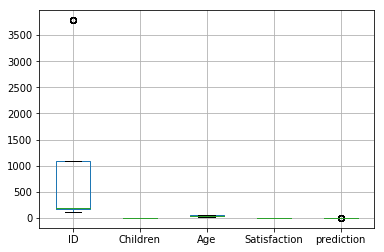

In [50]:
%matplotlib inline

pandas_df.boxplot()

### 5.2 Accessing data mart metrics
- performance
- quality
- fairness

Get all metrics.

In [51]:
deployments_metrics = client.data_mart.get_deployment_metrics()

Get metric for particular deployment.

In [52]:
subscription.quality_monitoring.get_metrics(deployment_uid=subscription.get_deployment_uids()[0])

{'end': '2018-11-15T14:50:21.987925Z',
 'metrics': [{'process': 'Accuracy_evaluation_0ec467a0-e220-408c-8218-042feda6bda1',
   'timestamp': '2018-11-15T14:47:22.601Z',
   'value': {'metrics': [{'name': 'weightedTruePositiveRate', 'value': 0.5},
     {'name': 'accuracy', 'value': 0.5},
     {'name': 'weightedFMeasure', 'value': 0.625},
     {'name': 'weightedRecall', 'value': 0.5},
     {'name': 'weightedFalsePositiveRate', 'value': 0.0},
     {'name': 'weightedPrecision', 'value': 1.0}],
    'quality': 0.5,
    'threshold': 0.7}}],
 'start': '2018-11-15T13:45:49.773Z'}

<a id="setup"></a>
## 6. Visualization

Get the performance metrics as pandas dataframe.

In [53]:
performance_pdf = subscription.performance_monitoring.get_table_content()

Let's enrich our data by calculating additional metric: `throughput`

In [54]:
performance_pdf['throughput'] = performance_pdf.apply(lambda row: float((row.scoring_records/row.scoring_time*1000)) ,axis=1)
performance_pdf['date'] = performance_pdf['ts'].dt.date
performance_aggregated_daily = performance_pdf.groupby(['date']).agg({'throughput': 'mean', 'scoring_records': sum, 'scoring_time': sum})

Let's plot metrics over time using plotly package.

In [55]:
import sys
import os
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]]))

Create a trace.

In [56]:
trace1 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['throughput'],
    orientation = 'h',
    name='throughput'
)

trace2 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['scoring_records'],
    orientation = 'h',
    name='records'
)

trace3 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['scoring_time'],
    orientation = 'h',
    name='response time'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Performance metrics daily',
    barmode='group',
    xaxis=dict(title='Metric value'),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.